In [1]:
%load_ext autoreload
%autoreload 2

equivalent_aug_chords = {
    "E_Augmented": "C_Augmented",
    "Ab_Augmented": "C_Augmented",
    
    "F_Augmented": "C#_Augmented",
    "A_Augmented": "C#_Augmented",
    
    "F#_Augmented": "D_Augmented",
    "Bb_Augmented": "D_Augmented",
    
    "G_Augmented": "Eb_Augmented",
    "B_Augmented": "Eb_Augmented",
}

In [2]:
import json
import os
from madmom.audio.chroma import DeepChromaProcessor
from featureExtraction import chromagram
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


wavfolder = "generated_chords/wav"

processor = DeepChromaProcessor()


deepchromas = list()
chromas = list()

instruments = list()
chords = list()
octaves = list()
inversions = list()
img_paths = list()

for audio in tqdm(os.listdir(wavfolder)):
    if audio.endswith(".wav"):
        
        path = os.path.join(wavfolder, audio)
        
        chroma = processor(path)
        deepchromas.append(chroma)

        img_path = os.path.join("imgs", audio.replace(".wav", ".png"))
        if not os.path.exists(img_path) and 0:
            plt.imshow(chroma, origin='lower', aspect='auto', resample=True)
            plt.savefig(img_path, bbox_inches='tight')
        img_paths += [img_path] * chroma.shape[0]

        try:
            instrument, chord, octave, inversion = re.findall(r"(.*)_(.*_.*)_(\d)_(\d).wav", audio)[0]
            instruments += [instrument] * chroma.shape[0]
            chords += [chord] * chroma.shape[0]
            octaves += [octave] * chroma.shape[0]
            inversions += [inversion] * chroma.shape[0]
        except:
            pass

# Account for augmented chords simmetry
chords = [equivalent_aug_chords.get(chord, chord) for chord in chords]

# Build the data matrix
X = np.vstack(deepchromas)

100%|██████████| 5040/5040 [00:38<00:00, 131.82it/s]


In [3]:
import pandas as pd
df = pd.DataFrame({"instruments": instruments, "chords": chords, "octaves": octaves, "inversions": inversions, "img_paths": img_paths})


In [4]:
#mask = (df["chords"].str.contains("Major")) & (df["instruments"] == "Clarinet")
df2 = df
X = X

chords = df2["chords"].values
instruments = df2["instruments"].values
octaves = df2["octaves"].values
inversions = df2["inversions"].values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


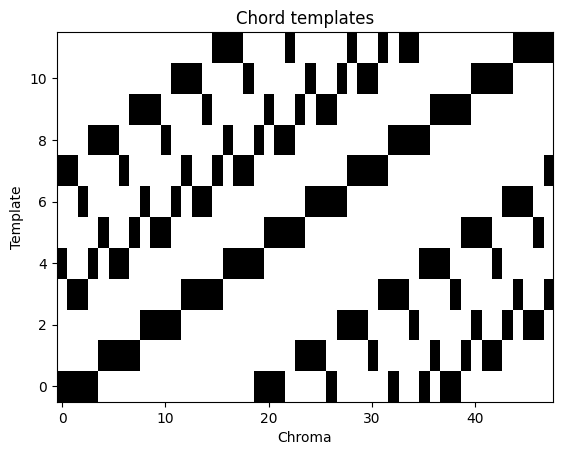

In [6]:
%load_ext autoreload
%autoreload 2
from dataProcessing import build_chord_templates
chord_templates = build_chord_templates()
#chord_templates = {k: v for k, v in chord_templates.items() if "Major" in k}
templates = np.array(list(chord_templates.values()))
plt.imshow(templates.T, origin='lower', aspect='auto', cmap='gray_r')
plt.title("Chord templates")
plt.xlabel("Chroma")
plt.ylabel("Template")
template_labels = list(chord_templates.keys())
template_labels = [equivalent_aug_chords.get(label, label) for label in template_labels]

### Baseline: Random Forest

In [7]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

RF = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)

# Evaluate the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(RF, X, chords, cv=cv, scoring='accuracy')
print(f"Mean accuracy: {np.mean(scores):.3f}")

Mean accuracy: 0.902


### Assess the optimal number of clusters based on coherence

In [8]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score
from sklearn.mixture import GaussianMixture

from tqdm import trange
rands = list()
mis = list()
fmis = list()
sil = list()
bics = list()
aics = list()
ks = list()


import json

for n in trange(24, 50):
    #kmeans = KMeans(n_clusters=n, random_state=123)
    gmm = GaussianMixture(n_components=n, covariance_type='full', init_params='kmeans', max_iter=1000, random_state=42)
    clusters = gmm.fit_predict(X)

    # Compute AIC and BIC
    bic = gmm.bic(X)
    aic = gmm.aic(X)
    bics.append(bic)
    aics.append(aic)
    rands.append(adjusted_rand_score(chords, clusters))
    mis.append(normalized_mutual_info_score(chords, clusters))
    fmis.append(fowlkes_mallows_score(chords, clusters))
    ks.append(n)
    #sil.append(silhouette_score(X, clusters))

metrics = {"rands": rands, 
           "mis": mis, 
           "fmis": fmis, 
           "sil": sil, 
           "bics": bics, 
           "aics": aics}

json.dump(metrics, open("gmm_metrics_all.json", "w"))

100%|██████████| 26/26 [12:29<00:00, 28.82s/it]


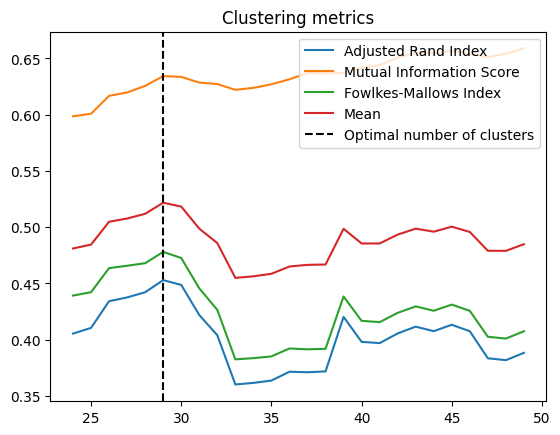

In [19]:

fig, axs = plt.subplots(1, 1)
axs.plot(ks, rands, label="Adjusted Rand Index")
axs.plot(ks, mis, label="Mutual Information Score")
axs.plot(ks, fmis, label="Fowlkes-Mallows Index")

# Mean of all metrics
axs.plot(ks, np.mean([rands, mis, fmis], axis=0), label="Mean")

# Add vline for optimal number of clusters
optim_n_rand = min(ks) + np.argmax(np.mean([rands, mis, fmis], axis=0))
axs.axvline(optim_n_rand, color='black', linestyle='--', label="Optimal number of clusters")

# axs[1].plot(ks, bics, label="BIC")
# axs[1].plot(ks, aics, label="AIC")
# axs[1].plot(ks, np.mean([bics, aics], axis=0), label="Mean")

# Add vline for optimal number of clusters
# optim_n_bic = np.argmin(np.mean([aics, bics], axis=0))
# axs[1].axvline(optim_n_bic, color='black', linestyle='--', label="Optimal number of clusters")

#plt.plot(sil, label="Silhouette Score")
axs.legend()
#axs[1].legend()

axs.set_title("Clustering metrics")
#axs[1].set_title("Information criteria")
# plt.suptitle("Optimal number of clusters")
# plt.axvline(14, color='black', linestyle='--', label="Optimal number of clusters")

plt.savefig("imgs/optimal_clusters_all.png", bbox_inches='tight')

In [20]:
print(optim_n_bic)
print(optim_n_rand)

25
29


### Fit the GMM with the optimal number of classes

In [21]:
gmm = GaussianMixture(n_components=optim_n_rand, covariance_type='full', init_params="kmeans", max_iter=1000, random_state=42)
clusters = gmm.fit_predict(X)

### Plot the clustering

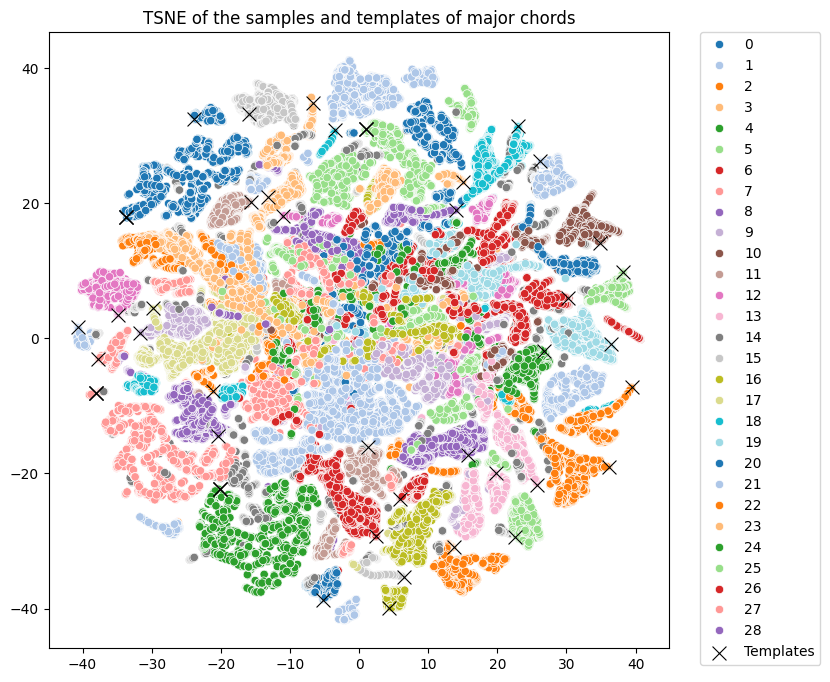

In [17]:
from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

def plot_clusters(coords, template_coords, clusters):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab20')
    #sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab20')

    sns.scatterplot(x=template_coords[:, 0], y=template_coords[:, 1], color='black', s=100, marker='x', label="Templates")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot the cluster assignments
tsne = TSNE(n_jobs=-1)
coords = tsne.fit_transform(np.vstack([X, templates]))
sample_coords = coords[:-len(templates)]
template_coords = coords[-len(templates):]

plot_clusters(sample_coords, template_coords, clusters)
plt.title("TSNE of the samples and templates of major chords")
plt.savefig("imgs/clusters_all.png", bbox_inches='tight')

### Compare distance within vs. distance between clusters

Mann Whitney's U test results:
* Statistic: 5.039e+05
* p-value: 2.429e-39


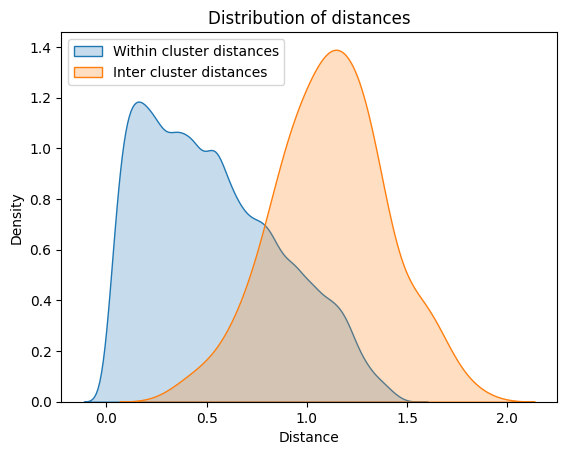

In [193]:
from scipy.spatial.distance import cdist, pdist

within = list()
cluster_centroids = list()
for i in np.unique(clusters):
    cluster_coords = X[clusters == i]
    centroid = cluster_coords.mean(axis=0)
    cluster_centroids.append(centroid)
    dists = pdist(cluster_coords)
    within.append(dists)


centroid_dists = pdist(cluster_centroids)

fig, ax = plt.subplots(1, 1)
sns.kdeplot(np.concatenate(within), ax=ax, fill=True, label="Within cluster distances")
sns.kdeplot(centroid_dists, ax=ax, fill=True, label="Inter cluster distances")
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Distribution of distances")
plt.savefig("imgs/distances_all.png", bbox_inches='tight')

from scipy.stats import mannwhitneyu
mw_test = mannwhitneyu(np.concatenate(within), centroid_dists)
print(f"Mann Whitney's U test results:\n* Statistic: {mw_test[0]:.3e}\n* p-value: {mw_test[1]:.3e}")




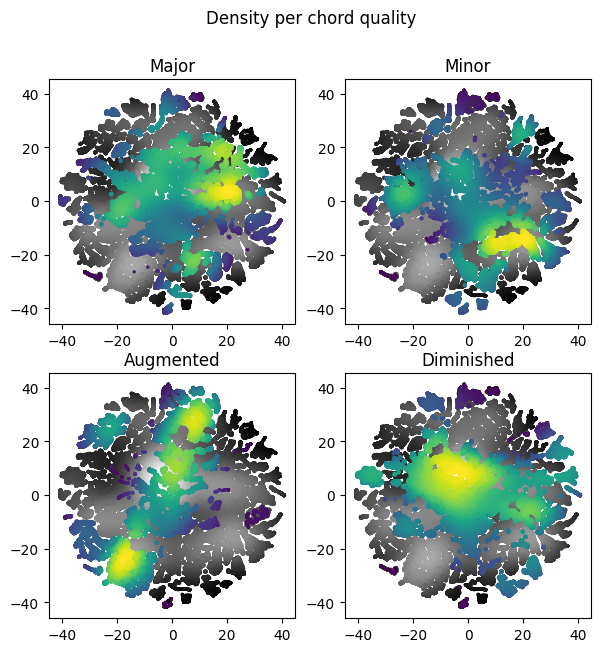

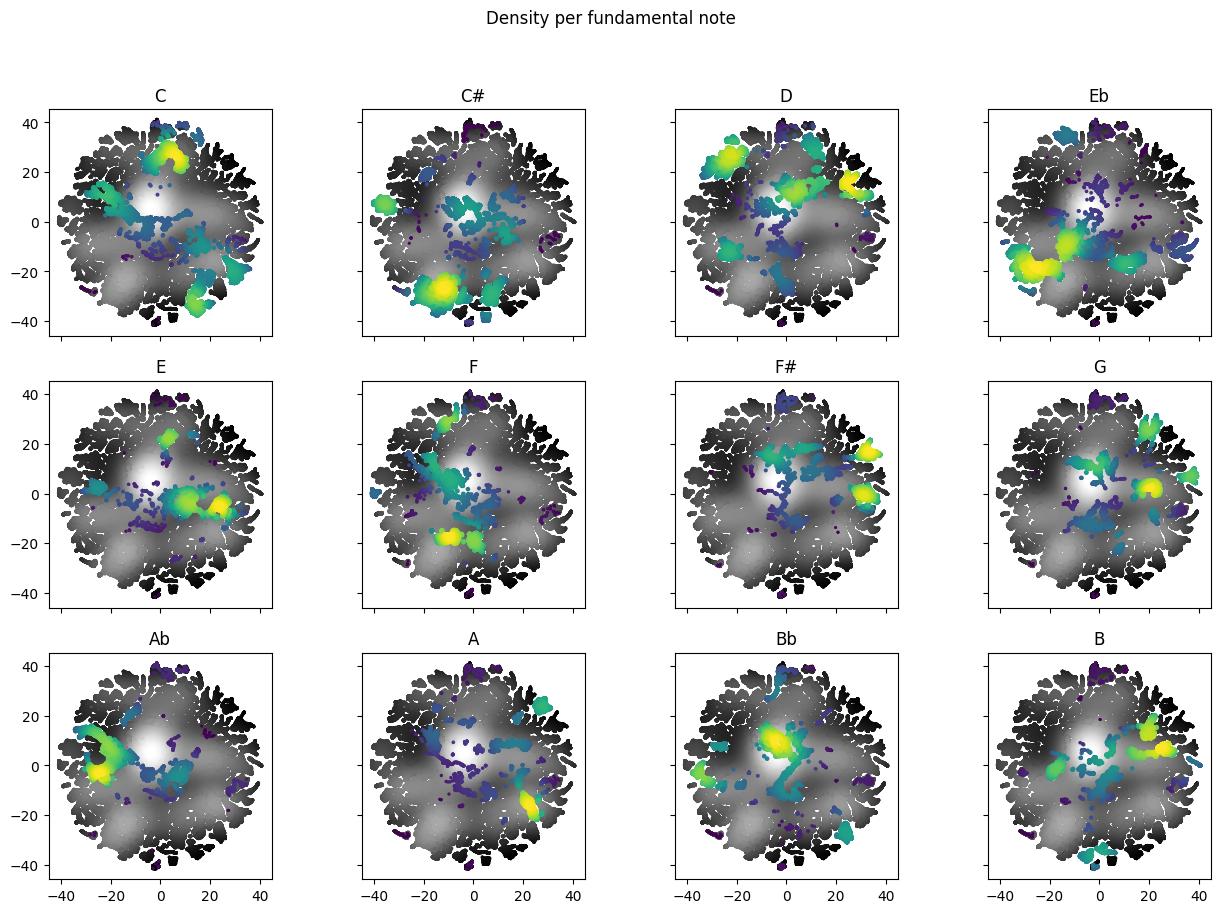

In [23]:
from scipy.stats import gaussian_kde
from sklearn.preprocessing import minmax_scale
import matplotlib

def projection(front, back=None, front_kwargs=[], ax=None,
               density_subsample=1000, update_proj_limits=True,
               min_point=5, proj_margin_perc=0.05):

    def _proj_range(P, margin_perc):
        xlim = [np.min(P[:, 0]), np.max(P[:, 0])]
        ylim = [np.min(P[:, 1]), np.max(P[:, 1])]
        abs_lim = np.max(np.abs(np.vstack([xlim, ylim])))
        margin = abs_lim * 2 * margin_perc
        proj_range = (- abs_lim - margin, abs_lim + margin)
        return proj_range, proj_range

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    if not isinstance(front, list):
        front = [front]

    if not isinstance(front_kwargs, list):
        front_kwargs = [front_kwargs]

    for proj, kwargs in zip(front, front_kwargs):
        x = proj[:, 0]
        y = proj[:, 1]

        density = kwargs.pop('density', False)
        density_kw = dict(cmap='viridis', s_min=5, s_max=20,
                          lw=0, density_subsample=1000)
        density_kw.update(kwargs.pop('density_kwargs', {}))

        contour = kwargs.pop('contour', False)
        contour_kw = dict(thresh=0, linewidths=0.8, levels=10,
                          contour_subsample=1000)
        contour_kw.update(kwargs.pop('contour_kwargs', {}))

        scatter_kw = dict()
        scatter_kw.update(kwargs.pop('scatter_kwargs', {}))

        if len(x) <= min_point and (contour or density):
            if contour:
                contour = False
                cmap = contour_kw['cmap']
            if density:
                density = False
                cmap = density_kw['cmap']
            if not callable(cmap):
                cmap = matplotlib.cm.get_cmap(cmap)
            scatter_kw = {'c':cmap(1.0), 's':density_kw['s_max']}

        if density:
            xy = np.vstack([x, y])
            density_subsample = density_kw.pop('density_subsample')
            z = gaussian_kde(xy[:, :density_subsample])(xy)
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]
            if 'c' not in density_kw:
                density_kw['c'] = z
            if 's' not in density_kw:
                s_min = density_kw.pop('s_min')
                s_max = density_kw.pop('s_max')
                density_kw['s'] = minmax_scale(z, (s_min, s_max))
            ax.scatter(x, y, **density_kw)
        elif contour:
            contour_subsample = contour_kw.pop('contour_subsample')
            sns.kdeplot(x=x[:contour_subsample], y=y[:contour_subsample],
                        ax=ax, **contour_kw)
        else:
            ax.scatter(x, y, **scatter_kw)

    all_projs = np.vstack(front)

    if update_proj_limits:
        xlim, ylim = _proj_range(all_projs, margin_perc=proj_margin_perc)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    return ax


fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs = axs.flatten()
for quality, ax in zip(["Major", "Minor", "Augmented", "Diminished"], axs):#, "Augmented", "Diminished"]:
    front = sample_coords[df2["chords"].str.contains(quality)]
    back = sample_coords
    ax.set_title(quality)
    try:
        projection(back, front_kwargs={"c": "grey", "density": True, "density_kwargs": {"cmap": "gray"}}, ax=ax, update_proj_limits=False)
        projection(front, back=back, front_kwargs={"c": "red", "density": True}, ax=ax, update_proj_limits=False)
    except:
        pass

plt.suptitle("Density per chord quality")
plt.savefig("imgs/clusters_per_quality_all.png", bbox_inches='tight')

notes = ["C", "C#", "D", "Eb", "E", "F", "F#", "G", "Ab", "A", "Bb", "B"]
#notes = ["Eb", ]

fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
axs = axs.flatten()
for chord_name, ax in zip(["C", "C#", "D", "Eb", "E", "F", "F#", "G", "Ab", "A", "Bb", "B"], axs):#, "Augmented", "Diminished"]:
    ax.set_aspect('equal')
    front = sample_coords[df2["chords"].str.split("_", expand=True)[0].str.fullmatch(chord_name)]
    back = sample_coords
    ax.set_title(chord_name)
    try:
        projection(back, front_kwargs={"c": "grey", "density": True, "density_kwargs": {"cmap": "gray"}}, ax=ax, update_proj_limits=False)
        projection(front, back=back, front_kwargs={"c": "red", "density": True}, ax=ax, update_proj_limits=False)
    except:
        pass

plt.suptitle("Density per fundamental note")
plt.savefig("imgs/clusters_per_fundamental_all.png", bbox_inches='tight')

### Assess the content of each cluster

In [24]:
import pandas as pd
# Count the proportion of each chord in each cluster
cluster_df = pd.DataFrame({'cluster': clusters, 'chord': chords})
cluster_df = cluster_df.groupby(['cluster'])["chord"].value_counts().reset_index()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cluster_df)

     cluster          chord  count
0          0    D_Augmented   4100
1          0       Bb_Major    145
2          0       F#_Major    117
3          0       Eb_Minor     92
4          0  Bb_Diminished     49
5          0   G_Diminished     46
6          0        G_Minor     42
7          0       Bb_Minor     41
8          0       Eb_Major     40
9          0   E_Diminished     36
10         0   Eb_Augmented     28
11         0   B_Diminished     26
12         0  Eb_Diminished     26
13         0   D_Diminished     22
14         0        D_Major     22
15         0  Ab_Diminished     14
16         0        B_Minor      9
17         0  F#_Diminished      9
18         0   C_Diminished      6
19         0       F#_Minor      4
20         0  C#_Diminished      1
21         0   F_Diminished      1
22         1   Eb_Augmented    646
23         1    D_Augmented    562
24         1    C_Augmented    454
25         1   C#_Augmented    441
26         1        B_Major    282
27         1        

### Create cluster labels

In [25]:
from sklearn.cluster import KMeans

template_clusters = gmm.predict(templates)

cluster_mapping = dict()
for cluster, label in zip(template_clusters, template_labels):
    cluster_mapping[cluster] = label

In [26]:
len(np.unique(template_clusters))

# Find repeated template_clusters
from collections import Counter
c = Counter(template_clusters)
repeated_clusters = [cluster for cluster, count in c.items() if count > 1]
repeated_clusters

[14]

In [27]:
for c, l in zip(template_clusters, template_labels):
    print(c, l)

13 C_Major
2 C_Minor
14 C_Diminished
14 C_Augmented
11 C#_Major
16 C#_Minor
14 C#_Diminished
14 C#_Augmented
20 D_Major
6 D_Minor
14 D_Diminished
14 D_Augmented
14 Eb_Major
14 Eb_Minor
14 Eb_Diminished
14 Eb_Augmented
23 E_Major
14 E_Minor
14 E_Diminished
14 C_Augmented
21 F_Major
14 F_Minor
14 F_Diminished
14 C#_Augmented
14 F#_Major
14 F#_Minor
14 F#_Diminished
14 D_Augmented
26 G_Major
14 G_Minor
25 G_Diminished
14 Eb_Augmented
22 Ab_Major
14 Ab_Minor
14 Ab_Diminished
14 C_Augmented
12 A_Major
14 A_Minor
14 A_Diminished
14 C#_Augmented
18 Bb_Major
14 Bb_Minor
14 Bb_Diminished
14 D_Augmented
15 B_Major
14 B_Minor
14 B_Diminished
14 Eb_Augmented


### Compute the "accuracy" of the clustering

In [28]:
gmm_y = list(map(lambda x: cluster_mapping.get(x, "None"), clusters))

from sklearn.metrics import accuracy_score
print(accuracy_score(chords, gmm_y))

0.17730654761904763


### Try it with a sequence of chords

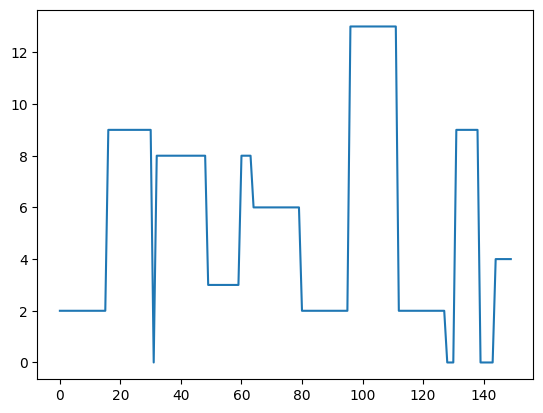

In [203]:
predictions = gmm.predict(X[:150])
plt.plot(predictions)

### Interactive TSNE

In [204]:
from faerun import Faerun
f = Faerun(clear_color="#111111", view="front", coords=False)

instruments = np.array(instruments).flatten()
img_paths = np.array(img_paths).flatten()
cat_chords, chord_data = Faerun.create_categories(chords)
cat_clusters, cluster_data = Faerun.create_categories(gmm_y)
cat_instruments, instruments_data = Faerun.create_categories(instruments)

misclassified = (np.array(chords) == np.array(gmm_y)).astype(str)
cat_misclassified, misclassified = Faerun.create_categories(misclassified)

labels = list()

for i in range(len(chord_data)):
    labels.append(f'{chords[i]}_{cluster_data[i]}__{instruments_data[i]}__<img src="{img_paths[i]}" width=500px>')

f.add_scatter(
    "embeddings",
    {
        "x": sample_coords[:, 0], 
        "y": sample_coords[:, 1], 
        "c": [chord_data, cluster_data, instruments_data, misclassified],
        "labels": labels,
    },
    colormap=["tab20", "tab20", "tab20"],
    shader="smoothCircle",
    point_scale=2,
    max_point_size=8,
    has_legend=[True, True, True, True],
    legend_labels=[cat_chords, cat_clusters, cat_instruments, cat_misclassified],
    categorical=[True, True, True, True],
    series_title=["True class", "Cluster", "Instruments", "Correctly classified"],
    selected_labels=["Cluster", "Instruments"],
    label_index=0,
    title_index=0
)

f.plot("TSNE_GMM", template="default")

/home/angel/SMC/mir/chordclustering/TSNE_GMM.html

In [187]:
cat_instruments

[(0, 'Bassoon'),
 (1, 'Clarinet'),
 (2, 'Contrabass'),
 (3, 'Flute'),
 (4, 'Guitar'),
 (5, 'Harp'),
 (6, 'Oboe'),
 (7, 'Piano'),
 (8, 'Piccolo'),
 (9, 'Saxophone'),
 (10, 'Trombone'),
 (11, 'Trumpet'),
 (12, 'Viola'),
 (13, 'Violin'),
 (14, 'Violoncello')]

# TODO

* Asignar a cada cluster su etiqueta según el template más cercano
* Analizar los que están mal clasificados
* Hacerlo solo con clarinete
* Hacerlo con todos los audios de music21
* Plottear el chord tracking para una secuencia de acordes
* Aplicar HMM/viterbi decoding (opcional)
* A ver si mejora poniendo un cluster más (para cuando no suena nada)

Most likely hidden state sequence: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 18 18 18  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 21  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7 15 15 20 20  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5 18  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4 22]


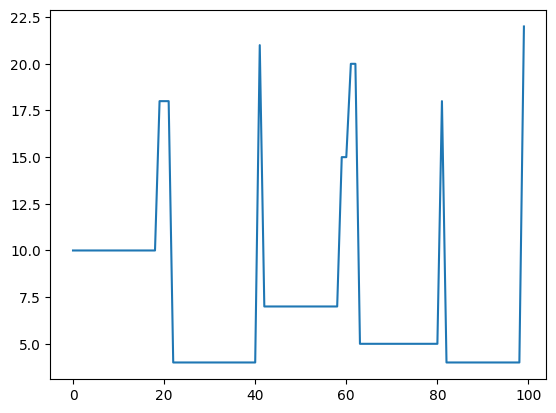

In [128]:
import numpy as np
from hmmlearn import hmm

n_states = 25  # Number of hidden states
n_observations = 25  # Number of observed classes

# Transition probability matrix (random uniform example)
transition_probs = np.full((n_states, n_states), 1/n_states)

# Emission probability matrix (random but normalized)
emission_probs = np.random.rand(n_states, n_observations)
emission_probs /= emission_probs.sum(axis=1, keepdims=True)  # Normalize rows

# Initial state probabilities (assuming equal probability)
start_probs = np.full(n_states, 1/n_states)

# Example observed sequence (indices of classes from 0 to 11)
observed_sequence = kmeans.predict(X[:100]).reshape(-1,1)

# Define and initialize HMM model
model = hmm.CategoricalHMM(n_components=n_states, n_iter=10000)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

# Apply Viterbi decoding
hidden_states = model.predict(observed_sequence)

print("Most likely hidden state sequence:", hidden_states)

plt.plot(hidden_states)